# Neural Networks from Scratch

~~Plagiarized from~~ Inspired by [Andrej Karparthy's cs231n](http://cs231n.github.io/neural-networks-case-study/) and [Colah's Blog](http://colah.github.io/posts/2015-08-Backprop/).

In [1]:
%matplotlib inline

#usual data science stuff
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

#utils
from utils import *

# Generate Data

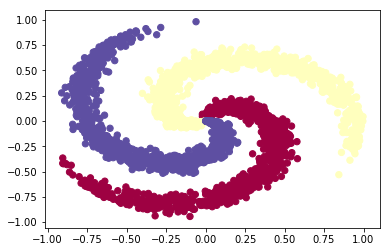

Shape of X: (3000, 2)
Shape of y: (3000,)


In [2]:
D = 2 #2 features
K = 3 #3 classes
N = 3000 #number of samples

X,y = spiral_gen(int(N/K),D,K)
print('Shape of X:',X.shape)
print('Shape of y:',y.shape)

# Initialize Weights

In [3]:
#Initialization
#weight
W = np.random.randn(D,K) # features x classes
print('Weight Shape:',W.shape)
#bias
b = np.random.randn(1,K)
print('Bias Shape:',b.shape)

reg = 1e-3
step_size = 1e-0

Weight Shape: (2, 3)
Bias Shape: (1, 3)


# Loss Functions

## Cross-Entropy Loss

For each example, the loss is the negative log of predicted probability of the correct class
$$L_i = -\sum_{k=1}^{K} y_klog(p_k)$$
where 
* $y_k$ is the true probability of the class; in 1 or 0
* $p_k$ is probability of a class
* $i$ is an example

The higher probability of the correct class, the lower the loss (for incorrect classes $y_k = 0$ so loss is 0)

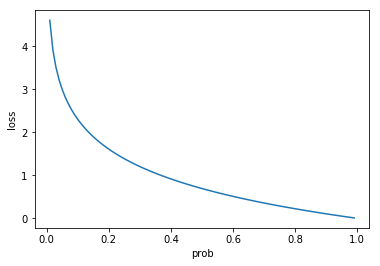

In [4]:
p = np.arange(0.01, 1, 0.01)
plt.plot(p,-np.log(p))
plt.xlabel('prob')
plt.ylabel('loss')

In [5]:
def cross_entropy(probs,y):
    #probs: N x K
    N = probs.shape[0]
    #print('All normalized probs:',probs.shape)
    
    #normalized prob of correct label
    correct_logprobs = -np.log(probs[range(N),y])
    #print('-log(normalized probs) when label is correct:',correct_logprobs.shape)
    
    #data loss
    data_loss = np.sum(correct_logprobs) / N
    
    return(data_loss)

#test
probs = np.random.random((3000,3))
print('Cross entropy loss: {}'.format(cross_entropy(probs,y)))

Cross entropy loss: 1.0091640381206317


## Hinge Loss

For an example, the loss per class per example is positive only when the score of wrong class is more than score of correct class by margin.

$$L_{i} = \sum_{other \ne correct}^{K} max(0,scores_{other} - scores_{correct} + \Delta)$$

Loss is positive only when the score of correct class is lower than an incorrect class, by magnitude more than margin.

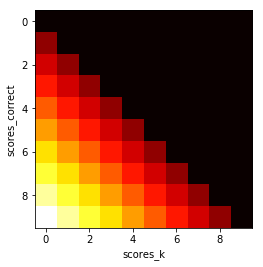

In [6]:
p = np.random.random((10, 10))
delta=1
for i in range(0,p.shape[0]):
    fk=i+1
    for j in range(0,p.shape[1]):
        fcorrect=j+1
        if i==j:
            p[i,j]=0
        else:
            p[i,j] = max(0,fk-fcorrect+delta)

plt.imshow(p, cmap='hot', interpolation='nearest')
plt.xlabel('scores_k')
plt.ylabel('scores_correct')
plt.show()

In [7]:
def hinge(scores,y):
    #scores: N x K
    N = probs.shape[0]
    
    correct_scores = scores[range(N),y]
   
    # need to broadcast by row not columns
    margin = scores.T - correct_scores + delta 
    margin = margin.T
    
    #zero loss at the correct label
    margin[range(N),y] = 0 
    
    #element-wise max
    margin = np.maximum(np.zeros(margin.shape),margin) 
    data_loss = np.sum(margin) / N

    
    return(data_loss)

#test
scores = np.random.random((3000,3))
print('Hinge loss: {}'.format(hinge(scores,y)))

Hinge loss: 2.0002012941385634


## Regularization
Data loss:

$$L_{data} = \frac{1}{N}\sum_{n=1}^{N}L_i$$

Regularization loss:

$$l1 = \frac{\lambda}{2}|W|$$
$$l2 = \frac{\lambda}{2}W^2$$

where $W$ is the weights

Overall loss:
$$L_{overall} = L_{data} + L_{reg}$$

In [8]:
def reg_loss_calc(W_list, l2=True, reg=1e-3):
    loss = 0
    if(l2):
        for i in range(len(W_list)):
            loss += 0.5 * reg * np.sum(W_list[i]* W_list[i])
    else:
        for i in range(len(W_list)):
            loss += 0.5 * reg * np.sum(abs(W_list[i]))
    return(loss)

#test
W_list = []
for i in range(4):
    W_list.append(np.random.randn(D,K))

print('L2 Loss: {}'.format(reg_loss_calc(W_list,l2=True)))
print('L1 Loss: {}'.format(reg_loss_calc(W_list,l2=False)))

L2 Loss: 0.010915586262271829
L1 Loss: 0.009426950400730444


# Layers

## Linear

### Forward Pass

$$scores = X \cdot W + b$$

### Backward Pass

$$\frac{\partial previous}{\partial W} = \frac{\partial previous}{\partial scores} \cdot \frac{\partial scores}{\partial W} = \frac{\partial previous}{\partial scores} \cdot X$$

$$\frac{\partial previous}{\partial b} = \frac{\partial previous}{\partial scores} \cdot \frac{\partial scores}{\partial b} = \frac{\partial previous}{\partial scores} \cdot 1$$

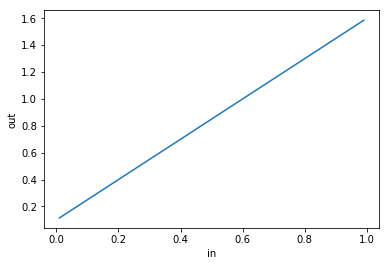

In [9]:
x = np.arange(0.01, 1, 0.01)
w = 1.5
b = 0.1
plt.plot(x,w*x + b)
plt.xlabel('in')
plt.ylabel('out')

In [10]:
class Linear:
    def forward(self,X,W,b):
        #X: N x D
        #W: D x K
        scores = X.dot(W) + b #N x K
        return(scores)
    def backward(self,X,W,previous,reg=1e-3):
        #previous: N x K
        dW = X.T.dot(previous)
        dW += reg * W
        db = np.sum(previous,axis=0,keepdims=True)
        return dW,db

#test
lin = Linear()
scores = lin.forward(X,W,b)
previous = np.ones_like(scores)
dW, db = lin.backward(X,W,previous)
print('Forward pass: {}'.format(scores.shape))
print('Backward pass: {}, {}'.format(dW.shape,db.shape))

Forward pass: (3000, 3)
Backward pass: (2, 3), (1, 3)


## Sigmoid

### Forward Pass

$$out = \frac{1}{1 + e^{-scores}}$$

### Backward Pass

$$\frac{\partial previous}{\partial scores} = \frac{\partial previous}{\partial out} \cdot \frac{\partial out}{\partial scores}
\\
\frac{\partial out}{\partial scores} = (-1) \cdot (\frac{1}{1+e^{-x}})^2 \cdot (-1) \cdot (\frac{1}{e^x})^2 \cdot e^x 
\\
= \frac{e^{-x}}{(1+e^{-x})^2} = \frac{1}{1+e^{-x}} \cdot \frac{e^{-x}}{1+e^{-x}} = out \cdot \frac{e^{-x}}{1+e^{-x}} \\
= out \cdot \frac{(1+e^{-x}) - 1}{1+e^{-x}} = out \cdot (1 - out)$$

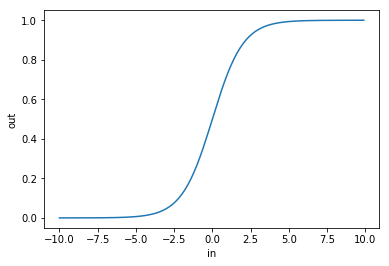

In [11]:
scores_p = np.arange(-10, 10, 0.1)
out_p = 1. / (1. + np.exp(-scores_p))
plt.plot(scores_p, out_p)
plt.xlabel('in')
plt.ylabel('out')

In [12]:
class Sigmoid:

    def forward(self,scores):
        #scores: N x K
        out = 1.0 / (1.0 + np.exp(-scores))
        return out
    
    def backward(self,scores,previous):
        out = self.forward(scores)
        dscores = (1.0 - out) * out * previous
        return(dscores)
#test
sig = Sigmoid()
out = sig.forward(scores)
dscores = sig.backward(scores,previous)
print('Forward pass: {}'.format(out.shape))
print('Backward pass: {}'.format(dscores.shape))

Forward pass: (3000, 3)
Backward pass: (3000, 3)


## Tanh

### Forward Pass

$$out = \tanh(scores)$$

### Backward Pass

$$\frac{\partial previous}{\partial scores} = \frac{\partial previous}{\partial out} \cdot \frac{\partial out}{\partial scores}
\\
\frac{\partial out}{\partial scores} = 1 - \tanh^2(scores) = 1 - out^2$$

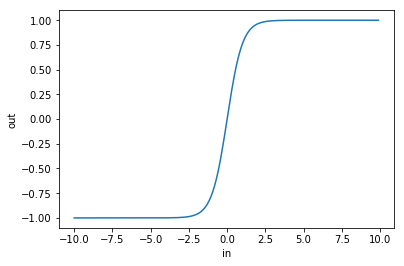

In [13]:
scores_p = np.arange(-10, 10, 0.1)
out_p = np.tanh(scores_p)
plt.plot(scores_p, out_p)
plt.xlabel('in')
plt.ylabel('out')

In [14]:
class Tanh:
    def forward(self,scores):
        #scores: N x K
        out = np.tanh(scores)
        return out
    
    def backward(self,scores,previous):
        out = self.forward(scores)
        dscores = (1.0 - np.square(out)) * previous
        return(dscores)
#test
tanh = Tanh()
out = tanh.forward(scores)
dscores = tanh.backward(scores,previous)
print('Forward pass: {}'.format(out.shape))
print('Backward pass: {}'.format(dscores.shape))

Forward pass: (3000, 3)
Backward pass: (3000, 3)


## ReLu
### Forward Pass

$$out = max(0,scores)$$

### Backward Pass

$$\frac{\partial previous}{\partial scores} = \frac{\partial previous}{\partial out} \cdot \frac{\partial out}{\partial scores}
\\
\frac{\partial out}{\partial scores} = 
\begin{cases}
1 & scores > 0 \\
0 & otherwise
\end{cases}$$

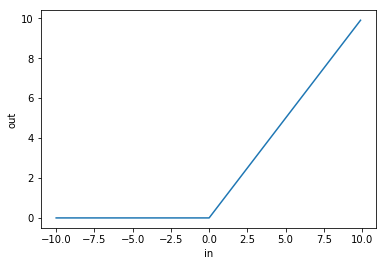

In [15]:
scores_p = np.arange(-10, 10, 0.1)
out_p = np.maximum(0,scores_p)
plt.plot(scores_p, out_p)
plt.xlabel('in')
plt.ylabel('out')

In [16]:
class ReLu:
    def forward(self,scores):
        #scores: N x K
        out = scores * (scores > 0)
        return out
    def backward(self, scores, previous):
        dscores = 1.0 * (scores > 0) * previous
        return(dscores)

#test
relu = ReLu()
out = relu.forward(scores)
dscores = relu.backward(scores,previous)
print('Forward pass: {}'.format(out.shape))
print('Backward pass: {}'.format(dscores.shape))

Forward pass: (3000, 3)
Backward pass: (3000, 3)


## Swish
### Forward Pass

$$out = scores \cdot \frac{1}{1 + e^{-scores}}$$

### Backward Pass

$$\frac{\partial previous}{\partial scores} = \frac{\partial previous}{\partial out} \cdot \frac{\partial out}{\partial scores}
\\
\frac{\partial out}{\partial scores} =scores \cdot \frac{\partial \sigma(scores)}{\partial scores} + \sigma(scores) \cdot 1\\
= scores  \cdot \sigma(scores) \cdot (1-\sigma(scores)) + \sigma(scores) \\
= scores \cdot \sigma(scores) - scores \cdot (\sigma(scores))^2 + \sigma(scores) \\
= out + \sigma(scores) \cdot (1-out)
$$

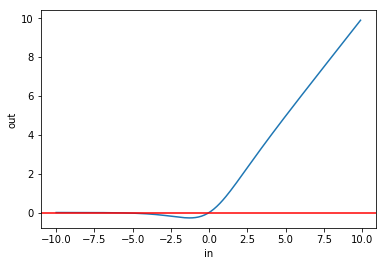

In [17]:
scores_p = np.arange(-10, 10, 0.1)
out_p = scores_p / (1. + np.exp(-scores_p))
plt.plot(scores_p, out_p)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('in')
plt.ylabel('out')

In [18]:
class Swish:
    def sigmoid(self,scores):
        out = 1.0 / (1.0 + np.exp(-scores))
        return out

    def forward(self,scores):
        #scores: N x K
        out = scores / (1.0 + np.exp(-scores))
        return out
    
    def backward(self,scores,previous):
        out = self.forward(scores)
        dscores = (out + self.sigmoid(scores) * (1-out)) * previous
        return(dscores)
#test
sw = Swish()
out = sw.forward(scores)
dscores = sw.backward(scores,previous)
print('Forward pass: {}'.format(out.shape))
print('Backward pass: {}'.format(dscores.shape))

Forward pass: (3000, 3)
Backward pass: (3000, 3)


## Softmax

Assume cross-entropy loss.

### Loss

For each example, the loss is the negative log of predicted probability of the correct class
$$L_i = -\sum_{k=1}^{K} y_klog(p_k)$$

### Forward Pass

$$p_{class} = \frac{e^{scores_{class}}}{\sum_{k=1}^{K} e^{scores_{k}}}$$


### Backward Pass

$$\frac{\partial L}{\partial scores_{class}} = \frac{\partial L}{\partial p_{class}} \cdot \frac{\partial p_{class}}{\partial scores_{class}} = - \frac{1}{p_{class}} \cdot \frac{\partial p_{class}}{\partial scores_{class}}
\\
\frac{\partial p_{class}}{\partial scores_{class}} = \frac{\sum_{k=1}^{K} e^{scores_{k}}e^{scores_{class}} - e^{2scores_{class}}}{(\sum_{k=1}^{K} e^{scores_{k}})^2} = p_{class} - p_{class}^2 = 
p_{class}(1-p_{class})\\
\frac{\partial L}{\partial scores_{class}} = p_{class} - 1 * y_{class}$$

In [19]:
class Softmax:
    def forward(self,scores):
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return(probs)
    
    def backward(self,scores,y):
        N = scores.shape[0]
        dscores = self.forward(scores)
        dscores[range(N), y] -= 1
        dscores /= N
        return(dscores)   
    
    def cross_entropy(self,probs,y):
        #probs: N x K
        N = probs.shape[0]
        #print('All normalized probs:',probs.shape)

        #normalized prob of correct label
        correct_logprobs = -np.log(probs[range(N),y])
        #print('-log(normalized probs) when label is correct:',correct_logprobs.shape)

        #data loss
        data_loss = np.sum(correct_logprobs) / N

        return(data_loss)
    
#test
soft = Softmax()
probs = soft.forward(scores)
dscores = soft.backward(scores,y)
loss = soft.cross_entropy(probs,y)
print('Forward pass: {}'.format(probs.shape))
print('Backward pass: {}'.format(dscores.shape))
print('Loss: {}'.format(loss))

Forward pass: (3000, 3)
Backward pass: (3000, 3)
Loss: 1.1208092012666093


## SVM

Assume hinge loss.

### Loss

$$L_{i} = \sum_{other \ne correct}^{K} max(0,scores_{other} - scores_{correct} + \Delta)$$

### Forward Pass

$$scores_k = (X \cdot W + b)_k$$

### Backward Pass

Derivative of loss function by weight
$$\frac{dL}{dscores} = 
\begin{cases}
\frac{dL}{dscores_{correct}} \\
\frac{dL}{dscores_{other}}
\end{cases}$$

$$\frac{dL}{dscores_{correct}} = 
\begin{cases}
\sum_{other \ne correct}^{K} (-1) & scores_{other} - scores_{correct} + \Delta > 0\\
0 & scores_{other} - scores_{correct} + \Delta <= 0
\end{cases}$$

$$\frac{dL}{dscores_{other}} = 
\begin{cases}
1  & scores_{other} - scores_{correct} + \Delta > 0 \\
0 & scores_{other} - scores_{correct} + \Delta <= 0\\
\end{cases}$$

In [20]:
class SVM:
    
    def forward(self,scores):
        return(scores)
    
    def forward_correct(self,scores,y):
        N = scores.shape[0]
        correct_scores = scores[range(N),y]
        return(correct_scores)
        
    def backward(self,scores,y):
        N = scores.shape[0]
        correct_scores = self.forward_correct(scores,y)
        # can broadcast by row not columns
        margin = scores.T - correct_scores + delta 
        margin = margin.T
        
        #zero loss at the correct label
        margin[range(N),y] = 0 
        
        #element-wise max
        margin = np.maximum(np.zeros(margin.shape),margin) 
        
        #binary to vectorize
        binary = margin
        #all derivatives whose scores are less than zero are zero
        binary[margin>0] = 1
        
        #sum to deduct from those with correct class only; the rest are to be 1
        col_sum = np.sum(binary,axis=1)
        binary[range(N),y] -= col_sum[range(N)]
        binary /= N
        return(binary)
        
    def hinge(self,scores,y):
        #scores: N x K
        N = probs.shape[0]

        correct_scores = scores[range(N),y]

        # need to broadcast by row not columns
        margin = scores.T - correct_scores + delta 
        margin = margin.T

        #zero loss at the correct label
        margin[range(N),y] = 0 

        #element-wise max
        margin = np.maximum(np.zeros(margin.shape),margin) 
        data_loss = np.sum(margin) / N
        
        return(data_loss)
    
#test
svm = SVM()
correct_scores = svm.forward_correct(scores,y)
dscores = svm.backward(scores,y)
loss = svm.hinge(scores,y)
print('Forward pass: {}'.format(correct_scores.shape))
print('Backward pass: {}'.format(dscores.shape))
print('Loss: {}'.format(loss))

Forward pass: (3000,)
Backward pass: (3000, 3)
Loss: 1.9147687317528252


# Training

## Linear > Softmax

In [21]:
iter = 1000
reg = 1e-3
step_size = 1e-0

#initialize weights
W = np.random.randn(D,K)
b = np.random.randn(1,K)
N = X.shape[0]

#Architecture: Linear > Softmax
lin = Linear()
soft = Softmax()

for i in np.arange(iter):
    #forward pass
    scores = lin.forward(X,W,b)
    probs = soft.forward(scores)
    loss = soft.cross_entropy(probs,y) + reg_loss_calc(W_list=[W])/N
    
    #report loss
    if i % 100 == 0:
        print("Iteration {}: loss {}".format(i, loss))
    
    #backward pass
    dscores = soft.backward(scores,y)
    dW, db = lin.backward(X,W,dscores,reg=1e-3)
    
    #update weights
    W += -step_size * dW
    b += -step_size * db

Iteration 0: loss 1.6480712876632464
Iteration 100: loss 0.7467210698444433
Iteration 200: loss 0.7418961943302339
Iteration 300: loss 0.7412924578526772
Iteration 400: loss 0.7411712831070048
Iteration 500: loss 0.7411433035511267
Iteration 600: loss 0.7411365931772121
Iteration 700: loss 0.7411349648804819
Iteration 800: loss 0.7411345659612796
Iteration 900: loss 0.7411344658585054


Accuracy: 0.5256666666666666


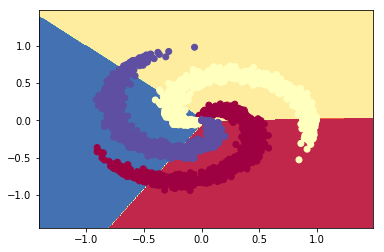

In [22]:
#prediction
def predict(X):
    pred = np.argmax(soft.forward(lin.forward(X,W,b)),axis=1)
    return(pred)

plot_decision_boundary(predict,X,y)
print('Accuracy: {}'.format(np.mean(predict(X)==y)))

## Linear > SVM

In [23]:
iter = 1000
reg = 1e-3
step_size = 1e-0

#initialize weights
W = np.random.randn(D,K)
b = np.random.randn(1,K)
N = X.shape[0]

#Architecture: Linear > SVM
lin = Linear()
svm = SVM()

for i in np.arange(iter):
    #forward pass
    scores = lin.forward(X,W,b)
    probs = svm.forward_correct(scores,y)
    loss = svm.hinge(scores,y) + reg_loss_calc(W_list=[W])/N
    
    #report loss
    if i % 100 == 0:
        print("Iteration {}: loss {}".format(i, loss))
    
    #backward pass
    dscores = svm.backward(scores,y)
    dW, db = lin.backward(X,W,dscores)
    
    #update weights
    W += -step_size * dW
    b += -step_size * db

Iteration 0: loss 3.6362799153808343
Iteration 100: loss 1.0552809580679352
Iteration 200: loss 1.055144780737008
Iteration 300: loss 1.0551351968527627
Iteration 400: loss 1.0551255057161155
Iteration 500: loss 1.0551238341201974
Iteration 600: loss 1.0551248467974454
Iteration 700: loss 1.0551251175362104
Iteration 800: loss 1.0551235580479865
Iteration 900: loss 1.0551223156053995


Accuracy: 0.527


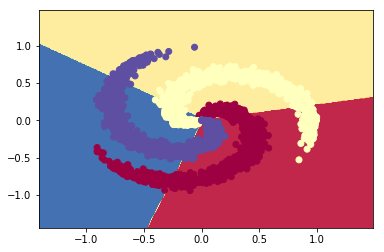

In [24]:
#prediction
def predict(X):
    pred = np.argmax(svm.forward(lin.forward(X,W,b)),axis=1)
    return(pred)

plot_decision_boundary(predict,X,y)
print('Accuracy: {}'.format(np.mean(predict(X)==y)))

## [Linear > Activation]++ > [Output > Softmax]

For the `[Linear > Output]` layer,

$$\frac{dL}{dW_{last}} = \frac{dL}{dscores_{last}} * \frac{dscores_{last}}{dW_{last}} $$

For the `[Linear > Activation]` layers,

$$\frac{dL}{dW_{nonlast}} = \frac{dL}{dscores_{previous}} * \frac{dscores_{previous}}{dscores_{nonlast}} * \frac{dscores_{nonlast}}{dW_{nonlast}} $$

$$\frac{dscores_{previous}}{dscores_{nonlast}} = 
\frac{d(scores_{nonlast}W_{previous} + b_{previous})}{dscores_{nonlast}} = W_{previous}$$

In [27]:
class DeepModel:
    def __init__(self,X,y,D,K,nb_layers,h_list,
                 activation,output_activation):
        #parameters
        self.X=X
        self.y=y
        self.nb_layers=nb_layers
        
        self.W_list = [None] * nb_layers
        self.b_list = [None] * nb_layers
        self.X_list = [None] * nb_layers
        self.X_list[0] = self.X

        self.act_list = [None] * nb_layers
        self.lin_list = [None] * nb_layers
        self.linout_list = [None] * nb_layers
        self.actout_list = [None] * nb_layers

        self.dscores_list = [None] * nb_layers
        self.dW_list = [None] * nb_layers
        self.db_list = [None] * nb_layers
    
        #randomize weights
        for i in range(nb_layers):
            #linear layers
            self.lin_list[i] = Linear()
            if (i == 0):
                self.W_list[i] = np.random.randn(D,h_list[i])
                self.b_list[i] = np.random.randn(1,h_list[i])
            elif (i==nb_layers-1):
                self.W_list[i] = np.random.randn(h_list[i-1],K)
                self.b_list[i] = np.random.randn(1,K)
            else:
                self.W_list[i] = np.random.randn(h_list[i-1],h_list[i])
                self.b_list[i] = np.random.randn(1,h_list[i])

            #activation layers
            if (i<nb_layers-1):
                self.act_list[i] = activation
            else:
                self.act_list[i] = output_activation

    def train(self,iter,reg,step_size,use_l2):
        nb_layers = self.nb_layers
        X_list = self.X_list
        act_list = self.act_list
        lin_list = self.lin_list
        actout_list = self.actout_list
        linout_list = self.linout_list
        dscores_list = self.dscores_list
        dW_list = self.dW_list
        db_list = self.db_list
        y = self.y
        
        for j in np.arange(iter):
            #forward
            for i in range(nb_layers):
                linout_list[i] = lin_list[i].forward(X_list[i],self.W_list[i],self.b_list[i])
                actout_list[i] = act_list[i].forward(linout_list[i])
                if (i < nb_layers-1): X_list[i+1] = actout_list[i]

            if type(act_list[nb_layers-1]) is Softmax:
                data_loss = act_list[nb_layers-1].cross_entropy(actout_list[nb_layers-1],y)
            else:
                data_loss = act_list[nb_layers-1].hinge(actout_list[nb_layers-1],y)
            reg_loss = reg_loss_calc(self.W_list,l2=use_l2,reg=reg)
            loss = data_loss + reg_loss

            if j % (iter/10) == 0:
                print('Loss at iteration {}: {}'.format(j,loss))

            #backward
            for i in reversed(range(nb_layers)):
                #backward activation
                if i < nb_layers-1:
                    dscores_list[i] = act_list[i].backward(X_list[i+1],dscores_list[i+1].dot(self.W_list[i+1].T))  
                else:
                    dscores_list[i] = act_list[i].backward(linout_list[i],y)   

                #backward linear
                dW_list[i],db_list[i] = lin_list[i].backward(X_list[i],self.W_list[i],dscores_list[i],reg=reg)

            #update
            for i in range(nb_layers):
                self.W_list[i] -= step_size * dW_list[i]
                self.b_list[i] -= step_size * db_list[i]  

    def pred(self,X):
        nb_layers = self.nb_layers
        X_list = self.X_list
        X_list[0] = X
        act_list = self.act_list
        lin_list = self.lin_list
        actout_list = self.actout_list
        linout_list = self.linout_list
        W_list = self.W_list
        b_list= self.b_list
        
        for i in range(nb_layers):
            linout_list[i] = lin_list[i].forward(X_list[i],W_list[i],b_list[i])
            actout_list[i] = act_list[i].forward(linout_list[i])
            if (i < nb_layers-1): X_list[i+1] = actout_list[i]
        pred = np.argmax(actout_list[nb_layers-1], axis=1)
        return pred

In [28]:
mod = DeepModel(X,y,D,K,nb_layers=2,h_list=[100],
                activation=ReLu(),output_activation=Softmax())

mod.train(iter=1000,reg=1e-3,step_size=1e-0,use_l2=True)
print('Accuracy: {}'.format(np.mean(y==mod.pred(X))))

Loss at iteration 0: 5.8156750409832645
Loss at iteration 100: 0.4077835645119065
Loss at iteration 200: 0.36144621329573345
Loss at iteration 300: 0.335131096066351
Loss at iteration 400: 0.3168484162021147
Loss at iteration 500: 0.30315044988675144
Loss at iteration 600: 0.29237046715490034
Loss at iteration 700: 0.2836946384638039
Loss at iteration 800: 0.27666828240030505
Loss at iteration 900: 0.27096623294334077
Accuracy: 0.989


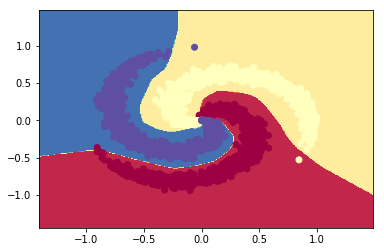

In [29]:
plot_decision_boundary(mod.pred,X,y)

# References
* [Stanford University CS231n](http://cs231n.github.io/neural-networks-case-study/): Convolutional Neural Networks for Visual Recognition by Andrej Karpathy
* Olah, Christopher. “Calculus on Computational Graphs: Backpropagation.” [Calculus on Computational Graphs: Backpropagation -- Colah's Blog](colah.github.io/posts/2015-08-Backprop/), 31 Aug. 2015.